# Deep Learning Project 1: Noah Dreifus


This new model, called the Genomic CNN model, was designed to see if a better prediction accuracy of promoter regions in plant genomes from Jores et al. could be achieved when compared to the hybrid or CNN models that are saved in EUGENe. The designed model contains three convolutional layers and 3 fully-connected or linear layers with filter sizes of 128.

In [1]:
%matplotlib inline

In [2]:
# Installing eugene tools
!pip install 'eugene-tools'

In [3]:
!pip install torchmetrics==0.10.1

  Using cached torchmetrics-0.10.1-py3-none-any.whl.metadata (15 kB)
Using cached torchmetrics-0.10.1-py3-none-any.whl (529 kB)
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 1.4.2
    Uninstalling torchmetrics-1.4.2:
      Successfully uninstalled torchmetrics-1.4.2


## Configuring

To make the sometimes painful process of keeping track of global parameters and input/output file paths easier, we usually like to set these through EUGENE's `settings` up front. This will control the default directories for things like:

- Data downloads with `seqdatasets`
- Model configuration files (i.e. EUGENe will know where to look for these files without you having to specify the full path every time)
- Model logs, checkpoints, and predictions
- Figures and plots

These small quality of life features can go a long way to preserve your sanity!

In [4]:
!git clone https://github.com/eugenp/tutorials.git

# Where the results will be saved
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/DLProject1")
cwd = os.getcwd()
cwd

fatal: destination path 'tutorials' already exists and is not an empty directory.
Mounted at /content/drive


'/content/drive/MyDrive/DLProject1'

In [5]:
# Configure EUGENe directories
from eugene import settings
settings.config_dir = "./tutorial_configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./tutorial_dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to
settings.figure_dir = "./tutorial_figures" # Directory to specify to EUGENe to save figures to

## Dataloading
For this project, we will reproduce the prediction of promoter activity featured in [Jores et al., 2021](https://www.nature.com/articles/s41477-021-00932-y) that uses DNA sequences as input to predict [STARR-seq activity](https://en.wikipedia.org/wiki/STARR-seq). We first need to load this dataset. If the dataset is a "EUGENe benchmarking dataset", it can be loaded in through the `SeqDatasets` [subpackage](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#seqdatasets-access-to-common-datasets). Let's load the package first

In [6]:
import seqdatasets

In [7]:
# Download the dataset to the dataset dir. We are using the promoters assayed in leaf promoters here
sdata = seqdatasets.jores21(dataset="leaf")
sdata

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170)
Dimensions without coordinates: _sequence, _length
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>

## Preprocessing
Now that we have our data loaded in, we can preprocess it using EUGENe's `preprocess` module. This module wraps functionality from the `SeqPro` [subpackage](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#sequence-manipulation-is-handled-efficiently-by-seqpro) and includes several functions for common sequence preprocessing tasks.

### Sequence preprocessing
Our first preprocessing step will be to one-hot encode our sequences. One-hot encoding is a common way to represent sequences as a matrix of 0s and 1s for model training. We will pass in DNA as the vocab explicitly, but this is the default if not specified.

In [8]:
from eugene import preprocess as pp

In [9]:
# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(sdata, alphabet="DNA")

Let's also quickly set-up some identifiers for our sequences. This will come in handy during interpretation when we often want to visualize the importance of specific sequences.

In [10]:
# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata)

### Dataset preprocessing
As is standard machine learning practice, we also need to split our data into training, validation, and test sets. This dataset comes with 'train' and 'test' labels in the 'set' annotation.

In [11]:
# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

We also need to split the training sequences into train and validation sets. We can do this using EUGENe's `train_test_random_split` function

In [12]:
# Split the training set into training and validation
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.2)

## Training
Now that we have our data ready, it's time to train our model! Training in EUGENe is done through the [PyTorch Lightning (PL) framework](https://www.pytorchlightning.ai/index.html). However PyTorch Lightning does not offer us much help with instantiating model architectures and initializing them. We will utilize EUGENE's library of neural network parts and architectures to do this.

### Instantiation and initialization
We first need to instantiate and initialize our model. We can use the `models` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#models-instantiate-and-initialize-neural-network-architectures) to do this.

In [13]:
from eugene import models

In [14]:
import importlib
import os
import torch
import yaml
from eugene import settings
from eugene import models
from eugene import train
from eugene import plot as pl
from matplotlib import pyplot as plt

We can also print out a summary of the model architecture using the `summary` function. Note that the configuration file we read in here also defines the LightningModule from PL that will be used to train the model. For more details on how this works, check out the [tutorial on instantiating and initializing models](https://github.com/ML4GLand/tutorials/blob/main/eugene/models/instantiating_models.ipynb).

In [15]:
# Change this to where you would like to save all your results, likely your tutorials download directory
import os
os.chdir("/content/drive/MyDrive/DLProject1/tutorials")  # TODO: change this to your own directory
cwd = os.getcwd()
cwd

'/content/drive/MyDrive/DLProject1/tutorials'

In [18]:
# NEW MODEL with 3 convolutional layers and 3 linear (fully connected) layers

import torch.nn as nn
import torch.nn.functional as F

class GenomicCNNModel(nn.Module):
    def __init__(self):
        super(GenomicCNNModel, self).__init__()

        # input and output length
        self.input_len = 170
        self.output_dim = 1

        # Convolutional Layers (1D) Using 1D because we are using sequential data (DNA sequences)
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=128, kernel_size=10, stride=1, padding=0)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=10, stride=1, padding=0)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=10, stride=1, padding=0)

        # Pooling Layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(1664, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.output_dim)  # Output layer for regression

    # defining the forward pass
    def forward(self, x):
        # Convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output from the convolutional layers into [batch_size, flattened_size]
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x



In [21]:
# Different way of printing out a summary of the new model
!pip install torchsummary
from torchsummary import summary

# Print the summary of the model
summary(model, input_size=(4, 4, 170))  #input size is (batch_size, channels, sequence_length)


NameError: name 'model' is not defined

When trying to print the summary of the model, I ran into some challenges. I couldn't use the model.summary() because my designed model does not have the attribute summary() to print out the parameters. I tried a different method to print out the summary using torchsummary and it initially worked, but after I made more changes to my model it stopped working and I haven't been able to fix whatever change I made.

### Model fitting

With a model intantiated and initialized, we are set up to fit our model to our plant promoters! We can do this through the `train` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#train-fit-parameters-to-your-data) in EUGENe

In [23]:
from eugene import train


If you are using GPU accelerators on your machine, you can can use the `gpus` argument to set the number gpus you want to use. If left empty, EUGENe will try to infer the number of GPUs available. Training the model with a single GPU will take less than 5 minutes. Check out the API and docstring for the function below for more details on the arguments you can pass in.

In [24]:
# Assigning wrapper function to new model
model = models.SequenceModule(
    arch=GenomicCNNModel(),
    task="regression",
    loss_fxn="mse",
    optimizer="adam",
    optimizer_lr=0.001,
    metric="r2score",
    scheduler="reduce_lr_on_plateau",
    scheduler_kwargs={'patience':3}
)

In [26]:
train.fit_sequence_module(
    model=model,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=15,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="GenomicCNNModel",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},
    gpus="auto"
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/DLProject1/tutorial_logs/GenomicCNNModel/tutorial_model/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RAN

No seed set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

We can see how our models trained over time by plotting a training summary. All you need to do is point the [training_summary](https://eugene-tools.readthedocs.io/en/latest/api/eugene.plot.training_summary.html#eugene.plot.training_summary) function to your the EUGENe logging directory.

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)


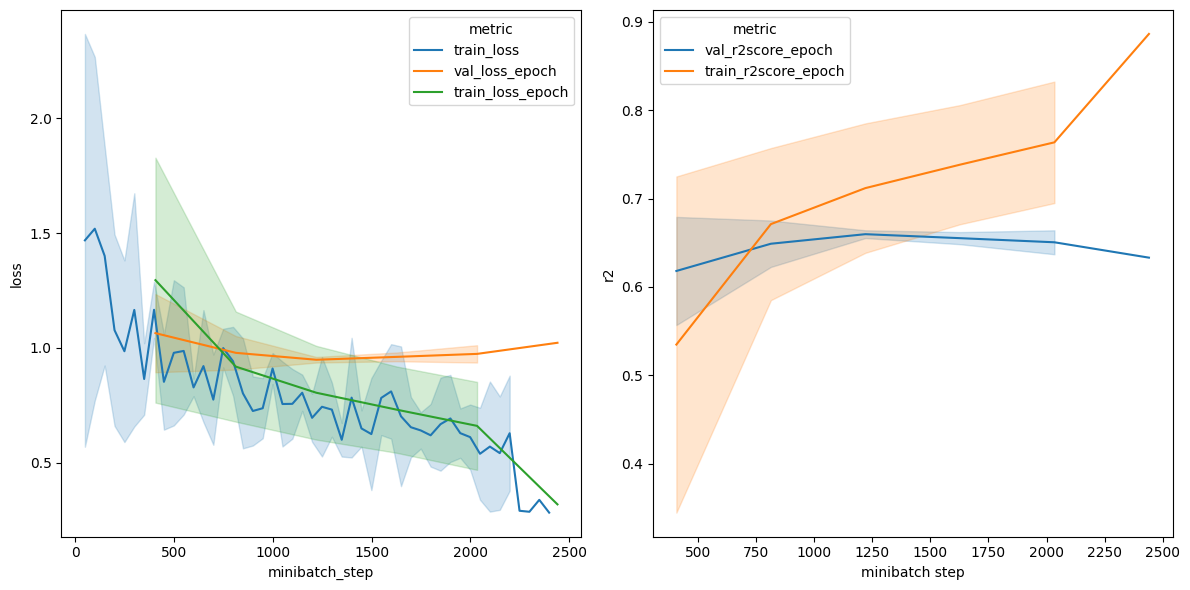

In [35]:
# Plot a loss curve and an r2 curve as a metric
pl.training_summary(os.path.join(settings.logging_dir, "GenomicCNNModel", "tutorial_model"), metric="r2")

#save figure
plt.savefig(os.path.join("/content/drive/MyDrive/DLProject1/Model_Results","Project1_Loss_curve.png"))

## Evaluation
After the model's been trained, we can evaluate our performance on our held-out test data. This is done through the `evaluate` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#evaluate-validate-and-explore-models-on-new-data).

In [28]:
from eugene import evaluate

We want to use our best model for evaluation. We can see from the training curve above that our model began overfitting the data after about 3000 training steps. Lucky for us, PyTorch Lightning keeps track of our best model for us! We can load this model in from the log directory like so

In [29]:
# We will use the glob Python library to help us find the path to our model
import glob

In [30]:
# We point to the checkpoints directory within the logging directory to grab the best model
model_file = glob.glob(os.path.join(settings.logging_dir, "PromoterCNN", "tutorial_model", "checkpoints", "*"))[0]
best_model = models.SequenceModule.load_from_checkpoint(model_file, arch=model.arch)

Our model is loaded in. Now let's make some predictions

In [31]:
# Use this best model to predict on the held-out data. This will store predictions in
evaluate.predictions_sequence_module(
    best_model,
    sdata=sdata_test,
    seq_var="ohe_seq",
    target_vars="enrichment",
    batch_size=2048,
    in_memory=True,
    name="GenomicCNNModel",
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},
    gpus = "auto"
)

Loading ohe_seq and ['enrichment'] into memory


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

We know have predictions from our trained model! Let's look at a scatterplot to see how we did

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.523593550340526 0.6635557252274208 0.6978446723697498
Sb 0.6570272533441477 0.931177147280466 0.8238504070236774
Zm 0.7124860329118352 0.8754359320306138 0.84823570620495


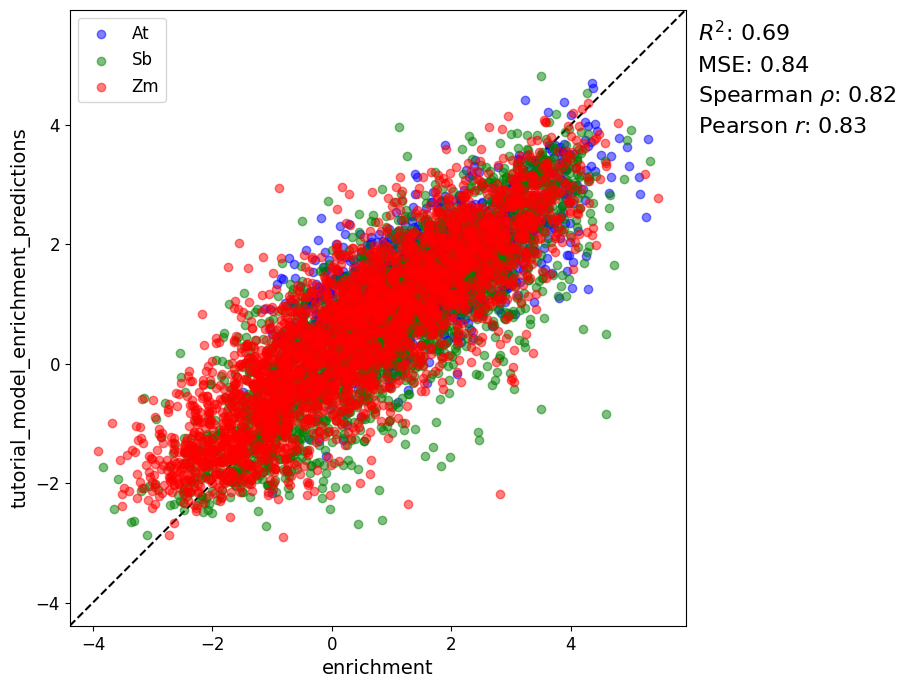

In [33]:
# plotting the predictions of the best trained model
pl.performance_scatter(
    sdata_test,
    target_vars="enrichment",
    prediction_vars="tutorial_model_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

#save figure
plt.savefig(os.path.join("/content/drive/MyDrive/DLProject1/Model_Results","Project1_Prediction_Accuracy.png"))

Not too shabby. We were able to train a more predictive model than EUGENe's CNN model with an R2 of 0.52. It is important to note that although the predictive accuracy may have increased, from the training summary it appears there was some significant overfitting of this model. More iterations of the model could be made and parameters of the model adjusted to reduce the overfitting.

---